In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [3]:
#
# Lectura de los datos
#
dataset = pd.read_csv('./AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


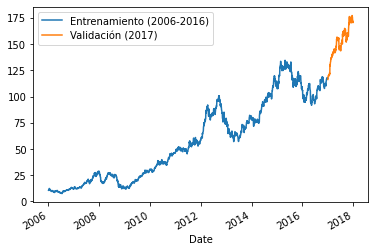

Epoch 1/20
85/85 [==============================] - 6s 37ms/step - loss: 0.0133
Epoch 2/20
85/85 [==============================] - 3s 35ms/step - loss: 0.0014
Epoch 3/20
85/85 [==============================] - 3s 41ms/step - loss: 8.5148e-04
Epoch 4/20
85/85 [==============================] - 3s 38ms/step - loss: 6.0971e-04
Epoch 5/20
85/85 [==============================] - 3s 39ms/step - loss: 4.4438e-04
Epoch 6/20
85/85 [==============================] - 4s 41ms/step - loss: 3.9519e-04
Epoch 7/20
85/85 [==============================] - 4s 46ms/step - loss: 3.2813e-04
Epoch 8/20
85/85 [==============================] - 3s 36ms/step - loss: 3.1630e-04
Epoch 9/20
85/85 [==============================] - 3s 37ms/step - loss: 2.9154e-04
Epoch 10/20
85/85 [==============================] - 5s 53ms/step - loss: 2.5854e-04
Epoch 11/20
85/85 [==============================] - 4s 45ms/step - loss: 2.4706e-04
Epoch 12/20
85/85 [==============================] - 4s 51ms/step - loss: 2.3661e-

In [4]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

/opt/anaconda3/envs/kerasTensor/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


6/6 [==============================] - 1s 14ms/step


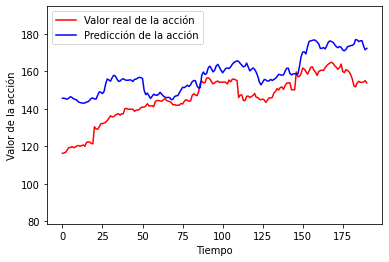

In [5]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)